In [1]:
%pylab inline
import os, sys
import emcee
import yaml
import astropy.io.ascii as ascii
from scipy import ndimage
from astropy.io import fits
from astropy.table import Table,join
import astropy as ap
from multiprocessing import Pool,Value
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import warnings
from functools import partial
import corner
from scipy.signal import savgol_filter
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
# from zg_utils import*
from astropy.modeling.functional_models import Sersic2D
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(Om0=0.3,H0=70)
import h5py
from scipy.ndimage import gaussian_filter

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/data/home/zihaoli/my_tools/") 
import spec_utils as su
import zg_utils

In [4]:
def A_lam(lam0, Av, Rv=3.1, verbose=False):
    lam0 = np.atleast_1d(lam0)
    assert len(lam0)==1, ' ERR: only allow len=1!'
    x   = 1. / lam0
    # assert (np.max(lam0) <= 1. / 1.1) and (np.min(lam0) >= 1. / 3.3), ' ERR: keyword value out of range'

    # Case 1: optical/NIR
    if 1.1<=x<=3.3:
        if verbose: print(' -   -   >   correcting dust for optical/NIR')
        xx  = x-1.82    # subtract off 1.82, which corresp to V-band in micron^-1
        #-------- define a(x) and b(x)
        a = lambda y: 1. + 0.17699*y - 0.50447*y**2. - 0.02427*y**3. + 0.72085*y**4. + 0.01979*y**5. - 0.77530*y**6. + 0.32999*y**7.
        b = lambda y: 1.41338*y + 2.28305*y**2. + 1.07233*y**3. - 5.38434*y**4. - 0.62251*y**5. + 5.30260*y**6. - 2.09002*y**7.
        #-------- calc A(lambda)
        Alam = Av * (a(xx) + b(xx) / Rv)

    # Case 2: infrared
    elif 0.3<=x<1.1:
        if verbose: print(' -   -   >   correcting dust for infrared')
        #-------- define a(x) and b(x)
        a = lambda y: 0.574*y**1.61
        b = lambda y: -0.527*y**1.61
        #-------- calc A(lambda)
        Alam = Av * (a(x) + b(x) / Rv)

    # Case 3: ultraviolet
    elif 3.3<x<=8.:
        if verbose: print(' -   -   >   correcting dust for ultraviolet')
        if x>=5.9:
            Fa = lambda y: -0.04473*(y-5.9)**2. - 0.009779*(y-5.9)**3.
            Fb = lambda y: 0.2130*(y-5.9)**2. + 0.1207*(x-5.9)**3.
        else:
            Fa = lambda y: 0
            Fb = lambda y: 0
        #-------- define a(x) and b(x)
        a = lambda y: 1.752 - 0.316*y - 0.104/((y-4.67)**2. + 0.341) + Fa(y)
        b = lambda y: -3.090 + 1.825*y + 1.206/((y-4.62)**2. + 0.263) + Fb(y)
        #-------- calc A(lambda)
        Alam = Av * (a(x) + b(x) / Rv)

    return Alam
def corrDust(flux, lineORlam0, Av, Rv=3.1, output='intrinsic', verbose=False):
#     print(lineORlam0)
    try:
#         lam0 = ELinfo[lineORlam0]['lam0']
        lam0 = ELinfo[lineORlam0]
    except:
        lam0 = lineORlam0
    if output == 'intrinsic':
        coef = 1.
        if verbose: print(' -   -   -   >   correct for dust to get *intrinsic* line flux')
    elif output == 'observed':
        coef = -1.
        if verbose: print(' -   -   -   >   correct for dust to get *observed* line flux')
    else:
        sys.exit(' ERR: keyword options not supported')
#     print([type(flux),type(coef),type(A_lam),type(lam0),type(Av),type(Rv)])
    return flux * 10.**(coef * 0.4 * A_lam(lam0 / 1.e4, Av, Rv=Rv))



Text(0, 0.5, 'ratio')

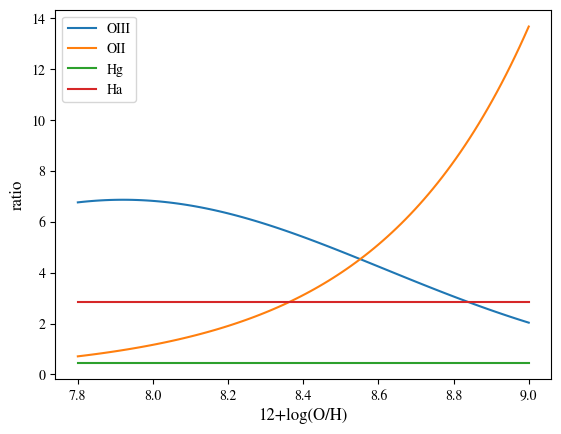

In [5]:
rootpath_caldb     = os.path.expanduser('')
fn_caldb           = 'calibr_sanders23.yml'

caldb = yaml.safe_load(open(os.path.join(rootpath_caldb, fn_caldb), 'r'))
oh12_norm = caldb['norm']
caldb_name = caldb['name'].replace('+','')
a = np.linspace(7.8,9,100)
plt.plot(a,10**np.polyval(caldb['OIII']['bestfit'][::-1],a),label='OIII')
plt.plot(a,10**np.polyval(caldb['OII']['bestfit'][::-1],a),label='OII')
plt.plot(a,10**np.polyval(caldb['Hg']['bestfit'][::-1],a),label='Hg')
plt.plot(a,10**np.polyval(caldb['Ha']['bestfit'][::-1],a),label='Ha')
plt.legend()
plt.xlabel('12+log(O/H)',fontsize=12)
plt.ylabel('ratio',fontsize=12)

In [6]:
ELinfo = {'OIII':5008.24,'OII':3727.092,'Hb':4862.71,'Hg':4341.692,'Ha':6563}

In [7]:
def z_mock(z,snr,Av,n=100):
    '''
    z: input metallicity
    snr: SNR of OIII line
    Av: dust attenuation
    n: number of output mock points
    '''
    
    ratio_OIII = 10**np.polyval(caldb['OIII']['bestfit'][::-1],z)*4/3
    ratio_OII = 10**np.polyval(caldb['OII']['bestfit'][::-1],z)
    ratio_Hg = 10**np.polyval(caldb['Hg']['bestfit'][::-1],z)
    ratio_Ha = 10**np.polyval(caldb['Ha']['bestfit'][::-1],z)

    # OIII flux is fixed at 10
    OIII = np.ones(n)*10
    Hb = OIII/ratio_OIII
    OII = Hb*ratio_OII
    Hg = Hb*ratio_Hg
    Ha = Hb*ratio_Ha
    
    OIII = corrDust(OIII, 5008.24, Av, output='observed')
    OII = corrDust(OII, 3727.092, Av, output='observed')
    Hg = corrDust(Hg, 4341.692, Av, output='observed')
    Hb = corrDust(Hb, 4862.71, Av, output='observed')
    Ha = corrDust(Ha, 6563, Av, output='observed')

    
    sig = OIII/snr
    Hg += sig*np.random.randn(n)
    OIII += sig*np.random.randn(n)
    OII += sig*np.random.randn(n)
    Hb += sig*np.random.randn(n)
    Ha += sig*np.random.randn(n)
    
    # set 1 sigma uppr limit
    # OIII = np.where(OIII<sig,sig,OIII)
    # OII = np.where(OII<sig,sig,OII)
    # Hb = np.where(Hb<sig,sig,Hb)
    # Hg = np.where(Hg<sig,sig,Hg)
    # Ha = np.where(Ha<sig,sig,Ha)

        
    out = Table({'id':np.arange(n)})
    out['flux_OIII'] = OIII
    out['flux_OII'] = OII
    out['flux_Hb'] = Hb
    out['flux_Ha'] = Ha
    out['flux_Hg'] = Hg
    out['err_OIII'] = sig
    out['err_Hb'] = sig
    out['err_Ha'] = sig
    out['err_Hg'] = sig
    out['err_OII'] = sig
    out['z_input'] = z
    out['root'] = 'mock'
    return out

In [8]:
from astropy.table import vstack

In [92]:
snr_arr = np.arange(2,22,1)
z_arr = np.arange(7.5,8.5,0.05)

In [20]:
dic = {}
n = 200
for snr in np.arange(2,22,2):
    snr_key = f'snr_{snr}'
    dic[snr_key] = {}
    for z in np.arange(7.5,8.5,0.05):
        z_key = f'Z_{z:.1f}'
        dic[snr_key][z_key] = z_mock(z,snr,0.1,n)

In [11]:
fn_caldb = '/home/zihaoli/data/JWST/metallicity/calibr_sanders23.yml'
# fn_caldb = '/home/zihaoli/data/JWST/metallicity/calibr_bian18.yml'

metal_analysis = zg_utils.metal_analysis(fn_caldb=fn_caldb,calib_range='upper',nwalkers=12)

In [24]:
out_dic = {}
for snr_key in dic:
    out_dic[snr_key] = {}
    for z_key in dic[snr_key]:
        data = dic[snr_key][z_key]
        out_z = metal_analysis.run_from_catalog(data,verbose=False,plot=False,save_path='.',nproc=200,
                                        lines=['OIII','OII','Ha','Hb','Hg'])
        out_dic[snr_key][z_key] = out_z

In [209]:
out_dic = np.load('z_mock_grid2.npy',allow_pickle=True).item()

In [218]:
out_dic = np.load('z_mock_grid_b18.npy',allow_pickle=True).item()

In [219]:
snr_arr = np.arange(2,22,1)
z_arr = np.arange(7.5,8.5,0.05)

d_z = (z_arr[1] - z_arr[0])/2
d_snr = (snr_arr[1] - snr_arr[0])/2
len(snr_arr),len(z_arr)

(20, 20)

In [220]:
z_grid = np.zeros(shape=(len(snr_arr),len(z_arr)))
z_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
for i,snr in enumerate(snr_arr):
    snr_key = f'snr_{snr}'
    for j,z in enumerate(z_arr):
        z_key = f'Z_{z:.2f}'
        data = out_dic[snr_key][z_key]['me']
        z_med = np.nanmedian(data)
        z_l,z_u = np.nanquantile(data,[0.16,0.84])
        e_l = z_med - z_l
        e_u = z_u - z_med
        dz = z - z_med
        z_grid[i,j] = dz
        z_rec[i,j] = z_med
        # if z_key == 'Z_8.2':
        #     print(dz)

In [225]:
full_dic = np.load('z_mock_grid2.npy',allow_pickle=True).item()

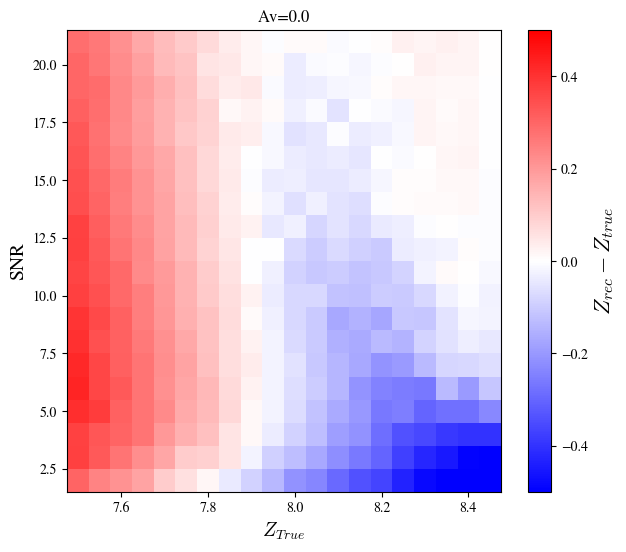

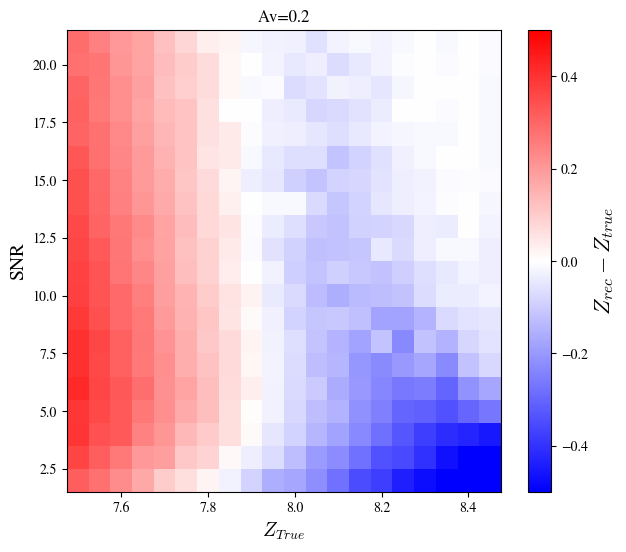

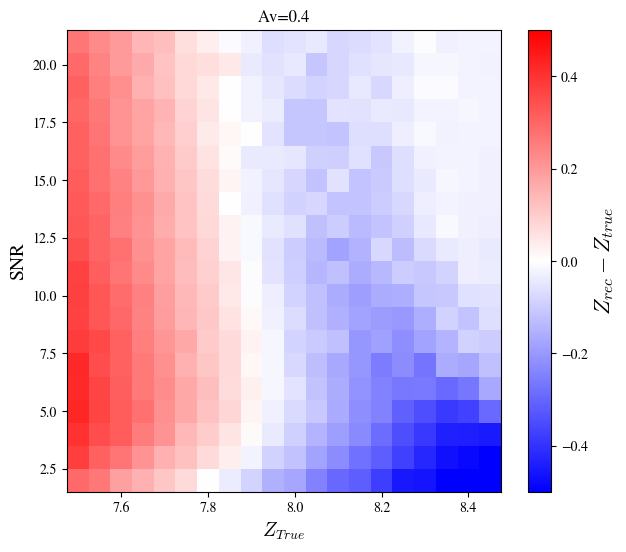

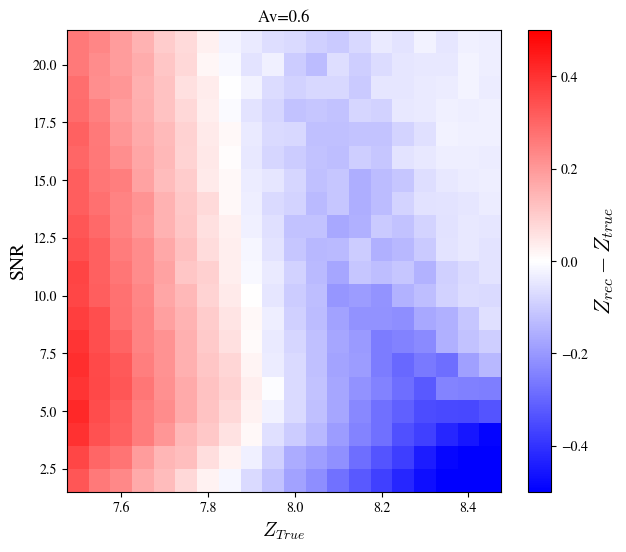

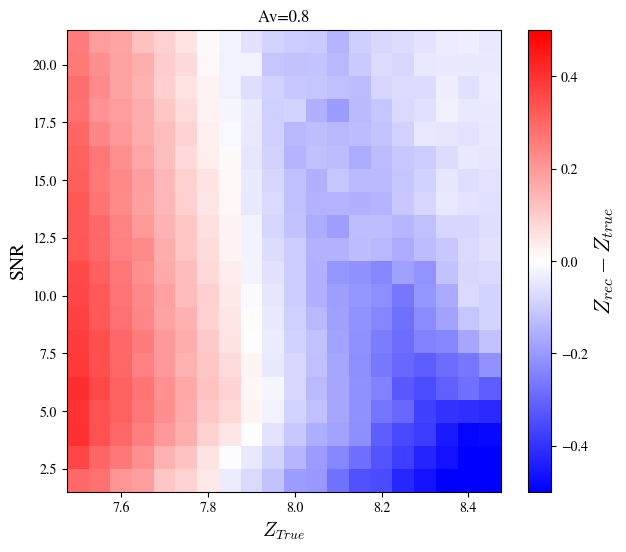

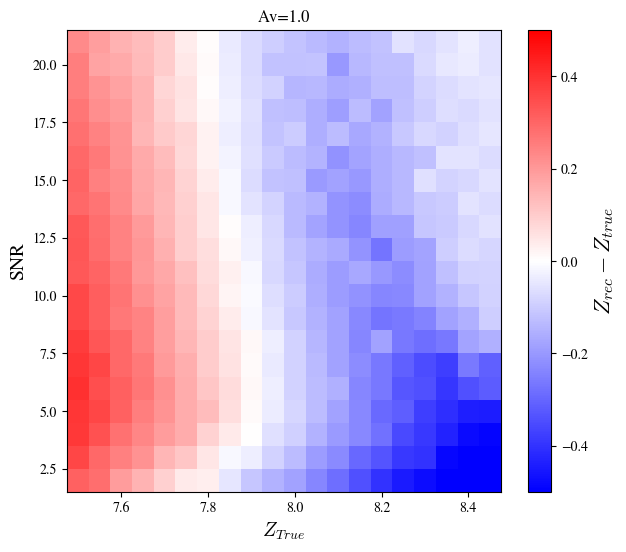

In [229]:
for Av_key in full_dic:
    this_dic = full_dic[Av_key]
    Av = Av_key.split('_')[1]
    z_grid = np.zeros(shape=(len(snr_arr),len(z_arr)))
    z_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
    for i,snr in enumerate(snr_arr):
        snr_key = f'snr_{snr}'
        for j,z in enumerate(z_arr):
            z_key = f'Z_{z:.2f}'
            data = this_dic[snr_key][z_key]['me']
            z_med = np.nanmedian(data)
            z_l,z_u = np.nanquantile(data,[0.16,0.84])
            e_l = z_med - z_l
            e_u = z_u - z_med
            dz = z - z_med
            z_grid[i,j] = dz
            z_rec[i,j] = z_med
    plt.figure(figsize=(7,6))
    plt.imshow(-z_grid,extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
               aspect='auto',origin='lower',interpolation='None',cmap='bwr',vmin=-0.5,vmax=0.5)
    cb = plt.colorbar()
    cb.set_label(label=r'$Z_{rec}-Z_{true}$',fontdict={'size':16})
    # plt.xticks(z_arr)
    # plt.yticks(snr_arr)
    plt.xlabel('$Z_{True}$',fontsize=14)
    plt.ylabel('SNR',fontsize=14)
    plt.title(f'Av={Av}')
    plt.show()

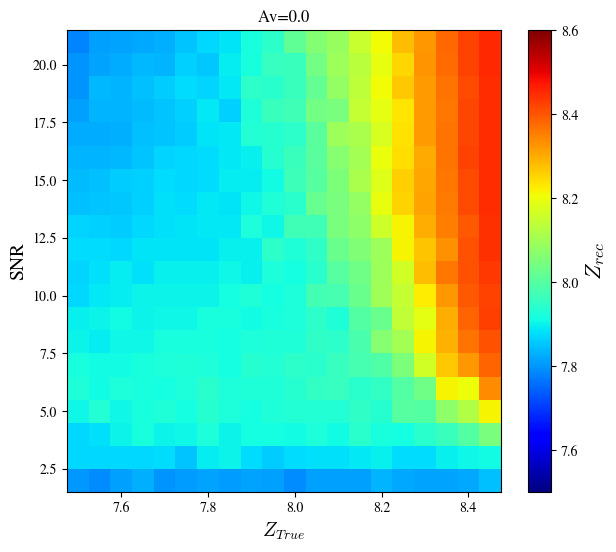

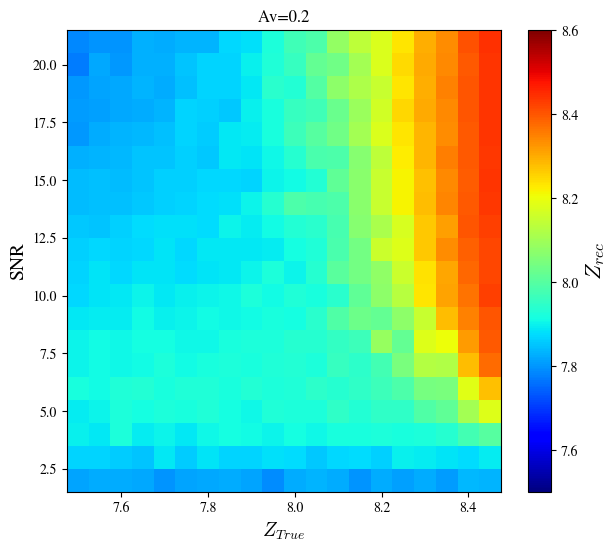

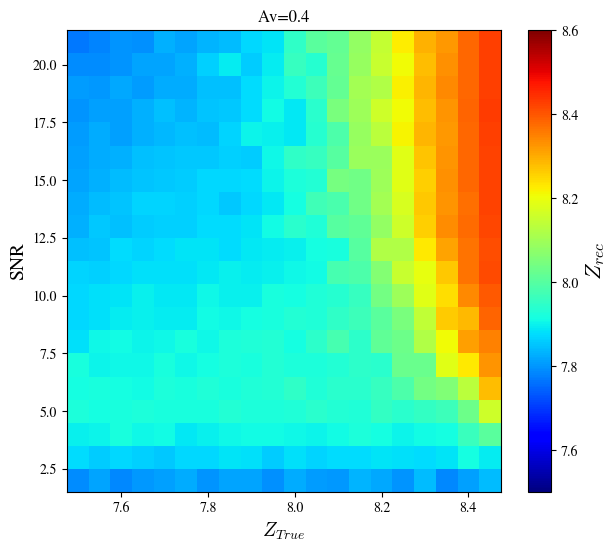

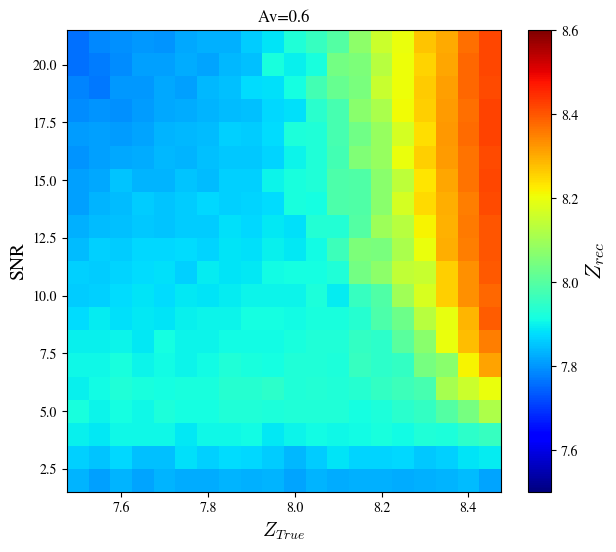

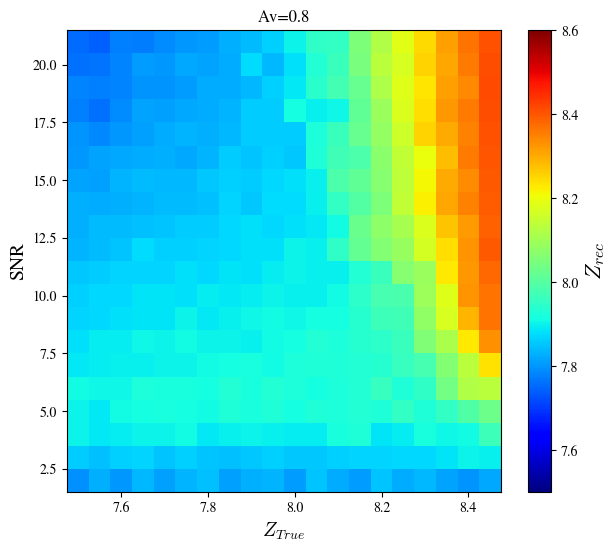

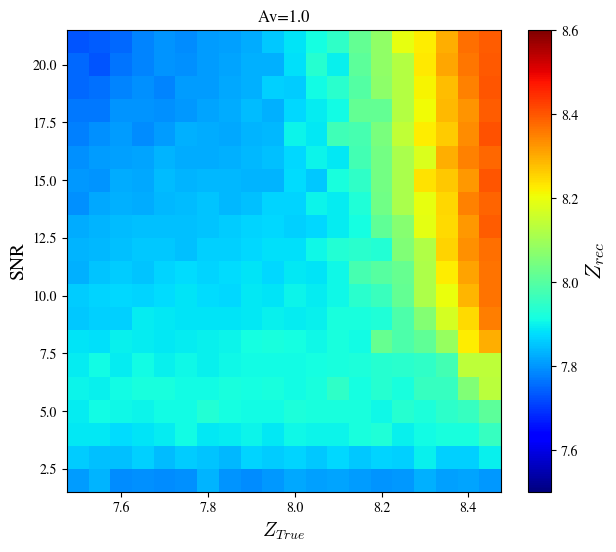

In [235]:
for Av_key in full_dic:
    this_dic = full_dic[Av_key]
    Av = Av_key.split('_')[1]
    z_grid = np.zeros(shape=(len(snr_arr),len(z_arr)))
    z_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
    for i,snr in enumerate(snr_arr):
        snr_key = f'snr_{snr}'
        for j,z in enumerate(z_arr):
            z_key = f'Z_{z:.2f}'
            data = this_dic[snr_key][z_key]['me']
            z_med = np.nanmedian(data)
            z_l,z_u = np.nanquantile(data,[0.16,0.84])
            e_l = z_med - z_l
            e_u = z_u - z_med
            dz = z - z_med
            z_grid[i,j] = dz
            z_rec[i,j] = z_med
    plt.figure(figsize=(7,6))
    plt.imshow(z_rec,extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
               aspect='auto',origin='lower',interpolation='None',cmap='jet',vmin=7.5,vmax=8.6)
    cb = plt.colorbar()
    cb.set_label(label=r'$Z_{rec}$',fontdict={'size':16})
    plt.xlabel('$Z_{True}$',fontsize=14)
    plt.ylabel('SNR',fontsize=14)
    plt.title(f'Av={Av}')
    plt.show()

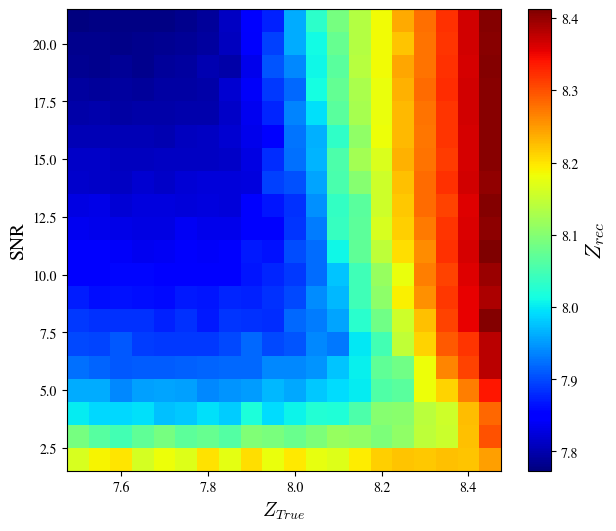

In [223]:
plt.figure(figsize=(7,6))
plt.imshow(z_rec,extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
           aspect='auto',origin='lower',interpolation='None',cmap='jet')
cb = plt.colorbar()
cb.set_label(label=r'$Z_{rec}$',fontdict={'size':16})
# plt.xticks(z_arr)
# plt.yticks(snr_arr)
plt.xlabel('$Z_{True}$',fontsize=14)
plt.ylabel('SNR',fontsize=14)
plt.show()

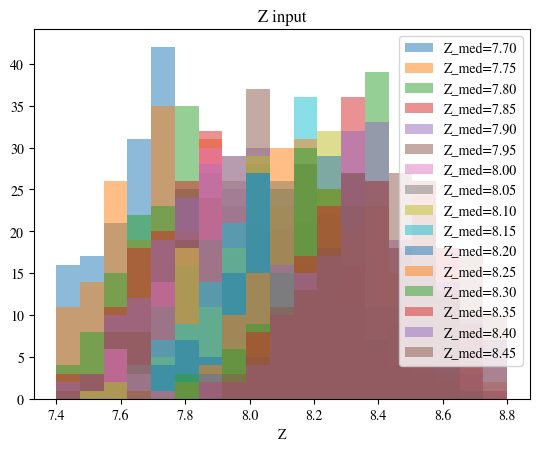

In [68]:
n = 200
import random

median_table_all = []

zmed_array = np.arange(7.7,8.5,0.05)
for zmed in zmed_array:
    Z = 0.2*np.random.randn(n)+zmed
    # out_table = z_mock
    out_table = []
    plt.hist(Z,alpha=0.5,label=f'Z_med={zmed:.2f}',histtype='stepfilled',bins=np.linspace(7.4,8.8,20))
    for this_Z in Z:
        out_table.append(z_mock(this_Z,10,0.1,n=1))
    
    out_table = vstack(out_table)
    
    # get the median of the 200 input mocks
    flux_oiii_stack = np.median(out_table['flux_OIII'])
    flux_oiii_stack_err = np.std([np.median(random.choices(out_table['flux_OIII'],k=n)) for i in range(100)])

    flux_oii_stack = np.median(out_table['flux_OII'])
    flux_oii_stack_err = np.std([np.median(random.choices(out_table['flux_OII'],k=n)) for i in range(100)])

    flux_Hb_stack = np.median(out_table['flux_Hb'])
    flux_Hb_stack_err = np.std([np.median(random.choices(out_table['flux_Hb'],k=n)) for i in range(100)])

    flux_Hg_stack = np.median(out_table['flux_Hg'])
    flux_Hg_stack_err = np.std([np.median(random.choices(out_table['flux_Hg'],k=n)) for i in range(100)])

    flux_Ha_stack = np.median(out_table['flux_Ha'])
    flux_Ha_stack_err = np.std([np.median(random.choices(out_table['flux_Ha'],k=n)) for i in range(100)])

    median_table = Table({'id':[0]})
    median_table['flux_OIII'] = flux_oiii_stack
    median_table['err_OIII'] = flux_oiii_stack_err

    median_table['flux_OII'] = flux_oii_stack
    median_table['err_OII'] = flux_oii_stack_err

    median_table['flux_Hb'] = flux_Hb_stack
    median_table['err_Hb'] = flux_Hb_stack_err

    median_table['flux_Hg'] = flux_Hg_stack
    median_table['err_Hg'] = flux_Hg_stack_err

    median_table['flux_Ha'] = flux_Ha_stack
    median_table['err_Ha'] = flux_Ha_stack_err
    
    median_table_all.append(median_table)
plt.legend()
plt.xlabel('Z')
plt.title('Z input')
median_table_all = vstack(median_table_all)

In [69]:
out_table = metal_analysis.run_from_catalog(median_table_all,verbose=False,plot=False,save_path='.',nproc=128,
                                        lines=['OIII','OII','Ha','Hb','Hg'])

Text(0, 0.5, '$\\mathrm{Z_{rec,stacking}}$')

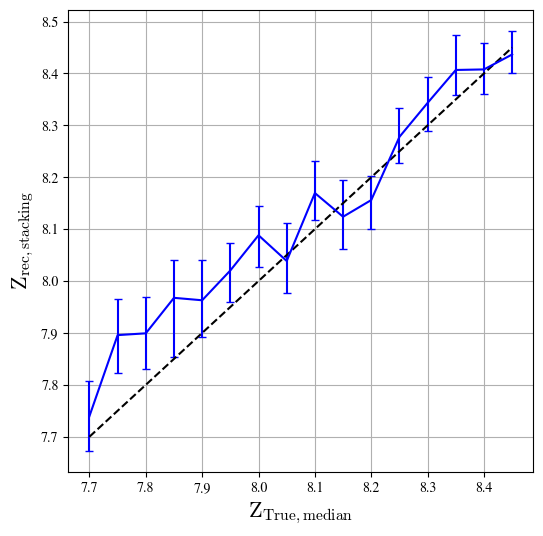

In [70]:
plt.figure(figsize=(6,6))
plt.errorbar(zmed_array,out_table['me'],
             yerr=(out_table['me_up1sig']-out_table['me'],
                   out_table['me']-out_table['me_low1sig']),
            color='b',capsize=3)
plt.plot(zmed_array,zmed_array,c='k',ls='--')
plt.grid()
plt.xlabel('$\mathrm{Z_{True,median}}$',fontsize=16)
plt.ylabel('$\mathrm{Z_{rec,stacking}}$',fontsize=16)